# Beehive

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import random
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

# from utils import decorate, savefig
# from scipy.signal import correlate2d
from Cell2D import Cell2D

In [92]:
class BUMBLE():
    bumble_states = ['egg', 'larva', 'pupa', 'worker', 'drone', 'queen', 'new queen']

    def __init__(self):
        # all BUMBLES originate in the center
        self.region = 'center'
        # TODO: find good amount of food to start with
        self.food = 5
        # universal variables to determine how ofter any BUMBLE performs an action; 10/day
        # ACT
        self.steps_per_day = 100
        self.actions_per_day = int(self.steps_per_day/10)
        # universal DODOM step STPDOM
        self.dominance_step = 0.15
        # Feeding parameters
        self.larva_feeding = 0.2
        self.queenlarva_feeding = 0.3


class EGG(BUMBLE):
    def __init__(self, location):
        super().__init__()
        self.state = 'egg'
        self.color = 'navy'
        self.location = location
        self.wait_time = -1

    def update(self):
        pass
    
    def evolve(self):
        """Remove the EGG BUMBLE and create a new LARVA
        """

class LARVA(BUMBLE):
    def __init__(self, location):
        super().__init__()
        self.state = 'larva'
        self.color = 'blue'
        self.location = location
        self.wait_time = -1

        self.deemed_new_queen = False

    def update(self):
        pass

    def evolve(self):
        """Remove the EGG BUMBLE and create a new LARVA
        """

class PUPA(BUMBLE):
    def __init__(self, location):
        super().__init__()
        self.state = 'pupa'
        self.color = 'deepskyblue'
        self.location = location
        self.wait_time = -1

    def update(self):
        pass

    def evolve(self):
        """Remove the EGG BUMBLE and create a new LARVA
        """

class WORKER(BUMBLE):
    def __init__(self, location):
        super().__init__()
        self.state = 'worker'
        self.color = 'lime'
        self.location = location
        self.dominance = 1
        # number of steps between actions
        self.wait_time = self.actions_per_day/self.dominance

    def update(self):
        pass

    def evolve(self):
        """Remove the EGG BUMBLE and create a new LARVA
        """

    def interact(self, other):
        """ Interact with another bee

        Other = the bee that is being interacted with
        """
        if other.state == 'worker' or other.state == 'queen':
            # DODOM dominance interaction
            R = self.dominance / (self.dominance + other.dominance)
            if (random.uniform(0,1)):
                K = 1
            else:
                K = 0
            self.dominance = self.dominance + (K-R)*self.dominance_step
            other.dominance = other.dominance - (K-R)*self.dominance_step
        
        elif other.state == 'larva':
            # feeds the larva
            self.food -= self.larva_feeding
            other.food += self.larva_feeding

        elif other.state == 'egg':
            pass


class DRONE(BUMBLE):
    def __init__(self, location):
        super().__init__()
        self.state = 'drone'
        self.color = 'aqua'
        self.location = location
    
    def update(self):
        pass

class NEW_QUEEN(BUMBLE):
    def __init__(self, location, dominance):
        super().__init__()
        self.state = 'new queen'
        self.color = 'deeppink'
        self.location = location
        self.dominance = dominance
        
    def update(self):
        pass

class QUEEN(BUMBLE):
    def __init__(self, location):
        super().__init__()
        self.state = 'queen'
        self.color = 'magenta'
        self.location = location
        self.dominance = 7.5
        
        # self.region = region
        # self.location = location
        # number of steps between actions
        self.wait_time = self.actions_per_day/self.dominance

    def update(self):
        pass

In [93]:
class Beehive(Cell2D):
    def __init__(self, n=25):
        self.zones = {'pot':3, 'center':2, 'periph':1, 'outside':0, 'egg':4, 'larva':5, 'pupa':6, 'worker':7, 'drone':8, 'queen':9, 'new queen':10}
        self.n = n
        self.day = 0
        # create hive space
        self.array = self.create_hive()
        self.empty_arr = self.array.copy()

        starting_loc = self.choose_random_loc('center')
        self.array[starting_loc] = self.zones['queen']
        self.bumbles = [QUEEN(starting_loc)]
        starting_eggs = 5
        for _ in range(starting_eggs):
            starting_loc = self.choose_random_loc('center')
            self.array[starting_loc] = self.zones['egg']
            self.bumbles.append(EGG(starting_loc))

        # region determines which other bee will be interacted with
        # self.center_bumbles = self.bumbles
        # self.periph_bumbles = []
        # self.outside_bumbles = []
        # self.honey_bumbles = []

        self.draw()
        
    def create_hive(self):
        """Creates the hive structure
        """
        # create circular sections
        X, Y = np.indices((self.n, self.n))
        bins = [int(self.n/2)-1, int(self.n/3)]
        grid = np.hypot(X-int(self.n/2), Y-int(self.n/2))
        hive = np.digitize(grid, bins)

        # create honeypot
        periph_row = np.argwhere(hive==1)[0][0]
        center_row = np.argwhere(hive==2)[0][0]
        honeypot_gap = center_row-periph_row
        hive[periph_row:center_row, int(self.n/2)-int(honeypot_gap/2):int(self.n/2)+int(honeypot_gap/2)+1] = 3
        return hive

    def choose_random_loc(self, zone):
        elements = np.where(self.array == self.zones[zone])
        return (np.random.choice(elements[0]), np.random.choice(elements[1]))

    def step(self):
        """ One time step during the day
        """
        for bee in self.bumbles:
            if (bee.wait_time == 0):
                bee.interact() # CHOOSE A RANDOM BEE
            bee.update()

    def draw(self):
        """draws the honeycomb
        """
        plt.imshow(self.empty_arr, cmap='YlOrRd')

        # draw the agents
        coords, colors = self.get_coords()
        for i in range(len(coords)):
            plt.plot([coords[i][0]], [coords[i][1]], '.', color = colors[i])
    
        plt.figure()
        plt.imshow(self.array, cmap='YlOrRd')
    def get_coords(self):
        """Gets the coordinates of the agents.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        np_coords = [bumble.location for bumble in self.bumbles]
        coords = [(i[1], i[0]) for i in np_coords]
        colors = [bumble.color for bumble in self.bumbles]
        print(np_coords, coords)
        return coords, colors

[(6, 12), (11, 10), (14, 14), (13, 18), (15, 7), (19, 13)] [(12, 6), (10, 11), (14, 14), (18, 13), (7, 15), (13, 19)]


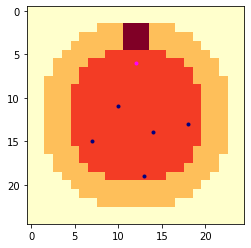

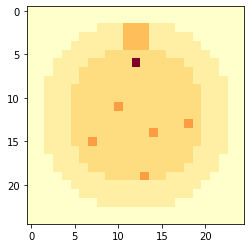

In [94]:
a = Beehive()
